In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [22]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

class ADNIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Get a list of subdirectories (labels) in the root directory
        self.labels = sorted(os.listdir(root_dir))

        # Create a mapping from label (subdirectory) to an integer
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}

        self.data = []
        self.targets = []

        # Create a dictionary to store the count of images for each class
        self.class_counts = {label: 0 for label in self.labels}

        # Iterate through subdirectories
        for label in self.labels:
            label_dir = os.path.join(root_dir, label)
            
            # Check if it's a directory
            if not os.path.isdir(label_dir):
                continue

            # Get a list of image files in the subdirectory
            image_files = [f for f in os.listdir(label_dir) if f.lower().endswith((".jpg", ".jpeg", ".png", ".gif"))]

            # Update class counts and append image paths and their corresponding labels
            for image_file in image_files:
                image_path = os.path.join(label_dir, image_file)
                self.data.append(image_path)
                self.targets.append(self.label_to_idx[label])
                self.class_counts[label] += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path).convert('L')

        if self.transform:
            image = self.transform(image)

        label = self.targets[idx]

        return image, label

    def get_class_counts(self):
        return self.class_counts

data_path = "D:/AD_NC/train"

train_dataset = ADNIDataset(data_path, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

(240, 256)


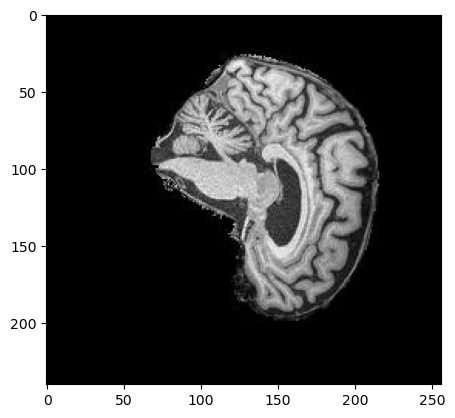

In [14]:
images, labels = next(iter(train_loader))
images = images.numpy()
print(images[0][0].shape)
plt.imshow(images[0][0], cmap='gray')
plt.show()

In [25]:
print("Number of samples:", len(train_loader.dataset))
class_counts = train_dataset.get_class_counts()
print("Number of classes:", class_counts)

Number of samples: 21520
Number of classes: {'AD': 10400, 'NC': 11120}


In [2]:
# Loading data
transform = ToTensor()
train_set = MNIST(root='D:\MNIST', train=True, download=True, transform=transform)
test_set = MNIST(root='D:\MNIST', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [3]:
# PATCHIFYING AND LINEAR MAPPING
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [4]:
# POSITIONAL ENCODING
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result


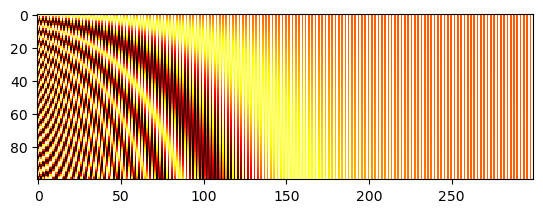

In [5]:
import matplotlib.pyplot as plt
plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

In [6]:
# LAYER NORMALISATION
# MULTI-HEAD SELF ATTENTION
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
    

In [7]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [8]:
model = MyViTBlock(hidden_d=8, n_heads=2)
x = torch.randn(7, 50, 8)  # Dummy sequences
print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


In [9]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

In [ ]:

model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

x = torch.randn(7, 1, 28, 28) # Dummy images
print(model(x).shape) # torch.Size([7, 49, 16])

In [ ]:
# model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
N_EPOCHS = 5
LR = 0.005

In [ ]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

In [ ]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

In [10]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [11]:
main()

100%|██████████| 9912422/9912422 [00:02<00:00, 3361272.82it/s]


Extracting ./../datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./../datasets\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 109890.49it/s]


Extracting ./../datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./../datasets\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2529074.72it/s]


Extracting ./../datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./../datasets\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4544496.37it/s]


Extracting ./../datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./../datasets\MNIST\raw

Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


Training:  20%|██        | 1/5 [08:24<33:38, 504.75s/it]

Epoch 1/5 loss: 2.13


Training:  40%|████      | 2/5 [16:23<24:28, 489.34s/it]

Epoch 2/5 loss: 1.91


Training:  60%|██████    | 3/5 [24:15<16:03, 481.57s/it]

Epoch 3/5 loss: 1.84


Training:  80%|████████  | 4/5 [32:08<07:58, 478.02s/it]

Epoch 4/5 loss: 1.80


Training: 100%|██████████| 5/5 [40:03<00:00, 480.62s/it]


Epoch 5/5 loss: 1.76


Testing: 100%|██████████| 79/79 [00:54<00:00,  1.45it/s]

Test loss: 1.72
Test accuracy: 74.18%
